In [20]:
#input files:
mtx_file = "Analysis/10X_PBMC/01_raw_data/gex_matrix/filtered_feature_bc_matrix/matrix.mtx.gz"
features_file = "Analysis/10X_PBMC/01_raw_data/gex_matrix/filtered_feature_bc_matrix/features.tsv.gz"
barcodes_file = "Analysis/10X_PBMC/01_raw_data/gex_matrix/filtered_feature_bc_matrix/barcodes.tsv.gz"

#output files:
idents_out_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_idents.RDS"
lib_size_out_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_lib_size.RDS"
rna_pca_out_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_pca.RDS"

In [4]:
library(Seurat)

Attaching SeuratObject
‘SeuratObject’ was built under R 4.3.1 but the current version is 4.3.3; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for R may have changed


In [5]:
setwd(here::here()) # set working directory to project root
getwd()

[1] "/sci/labs/yotamd/lab_share/avishai.wizel/Projects/eRNA"

In [6]:
pbmc.data <- Read10X(data.dir = dirname(mtx_file))


10X data contains more than one type and is being returned as a list containing matrices of each type.


In [7]:
names(pbmc.data)

[1] "Gene Expression" "Peaks"          

# 10X PBMC clustering using Seurat
This notebook adds a minimal Seurat workflow: create Seurat object from Read10X output (variable `PBMC` in earlier cell), QC/filtering, normalization, PCA, clustering, UMAP, and marker finding. Adjust filtering thresholds and clustering resolution to your dataset.

In [8]:
# Create Seurat object and perform basic QC
library(dplyr)

# `PBMC` was created earlier with Read10X
pbmc <- CreateSeuratObject(counts = pbmc.data[[1]], project = "PBMC10K", min.cells = 3, min.features = 200)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



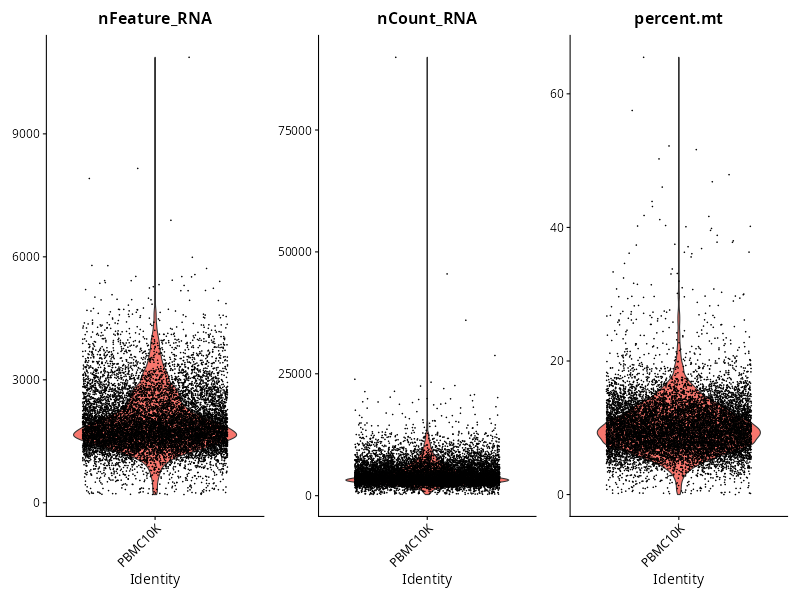

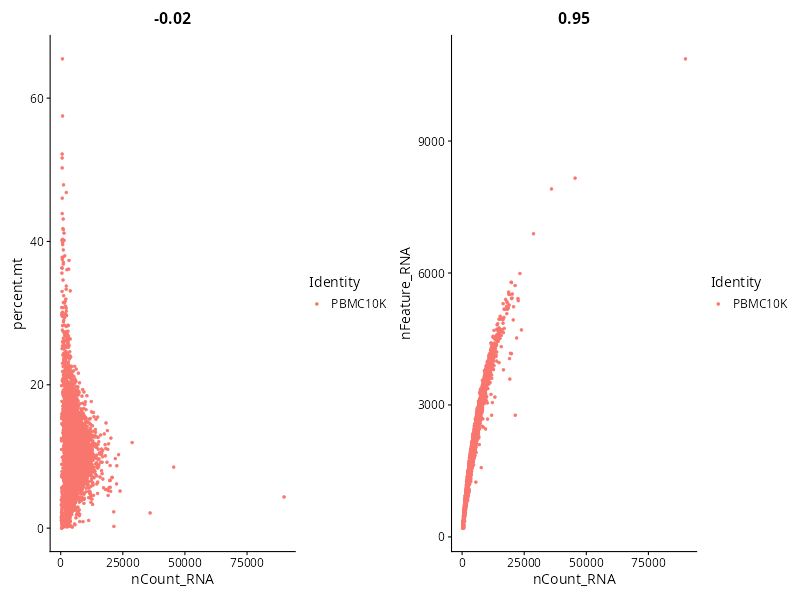

In [9]:


# percent mitochondrial genes (human: MT- prefix)
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

# QC plots
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2



In [10]:
# Filter cells - adjust thresholds as needed
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 3000 & percent.mt < 25)

pbmc

An object of class Seurat 
26346 features across 10628 samples within 1 assay 
Active assay: RNA (26346 features, 0 variable features)

In [11]:
lib_size_gex <- colSums(GetAssayData(pbmc, assay = "RNA", slot = "counts"))
names(lib_size_gex) <- colnames(pbmc)

Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Warning message:
In scale_x_log10() :
  log-10 transformation introduced infinite values.


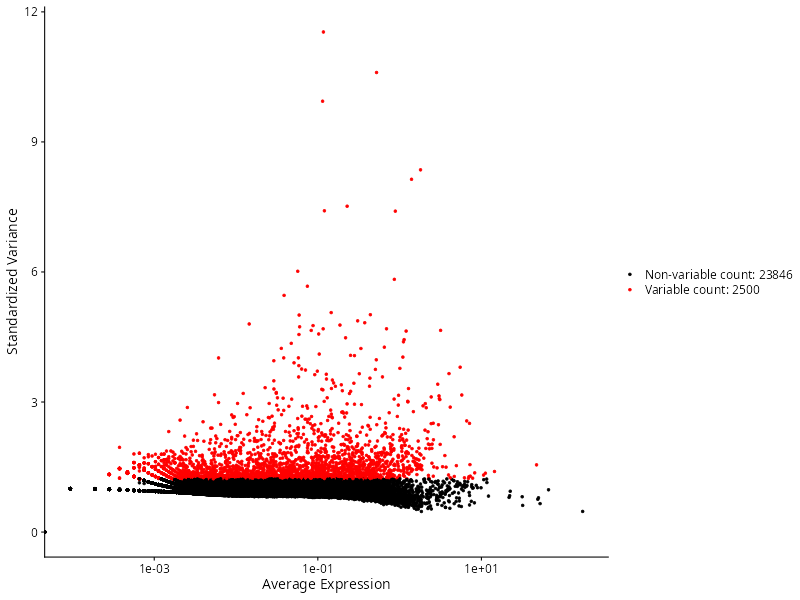

In [12]:
# Normalization, dimensionality reduction and clustering

# Normalize and identify variable features
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 1e6)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2500)

# Visualize variable features
top10 <- head(VariableFeatures(pbmc), 10)
VariableFeaturePlot(pbmc)




Centering and scaling data matrix


  |======================================================================================================================================| 100%


PC_ 1 
Positive:  SLC8A1, PLXDC2, LRMDA, RBM47, IRAK3, MCTP1, DMXL2, LRRK2, CSF3R, TNFAIP2 
	   TBXAS1, CLEC7A, GAB2, TLR2, HCK, FCN1, NAMPT, CYBB, FGD4, LYN 
	   JAK2, CD36, TYMP, ZEB2, FAM49A, STX11, MARCH1, SLC11A1, AC020916.1, CPPED1 
Negative:  BCL11B, CD247, CAMK4, RPS27, IL32, BACH2, LEF1, IL7R, INPP4B, BCL2 
	   SYNE2, CD96, LTB, THEMIS, RPS12, EEF1A1, RPS18, RORA, RPS29, RPS14 
	   TRBC2, RPL10, TXK, ANK3, STAT4, RPS23, GRAP2, CCR7, RPS15A, CARD11 
PC_ 2 
Positive:  PAX5, MS4A1, FCRL1, BANK1, EBF1, LINC00926, NIBAN3, OSBPL10, CD22, IGHM 
	   COBLL1, CD79A, BLK, BLNK, AP002075.1, COL19A1, IGHD, ADAM28, AFF3, RALGPS2 
	   PLEKHG1, CD79B, AC120193.1, DENND5B, GNG7, FCRL2, LINC02397, BCL11A, SPIB, FCER2 
Negative:  BCL11B, CD247, IL32, DPYD, AOAH, INPP4B, IL7R, CAMK4, THEMIS, PDE3B 
	   LEF1, TXK, RORA, ANXA1, STAT4, SLCO3A1, SRGN, NEAT1, ADGRE5, ARHGAP26 
	   FNDC3B, GNAQ, TRBC1, NCALD, IPCEF1, SAMD3, ID2, APBA2, PLCB1, GRAP2 
PC_ 3 
Positive:  LEF1, PDE3B, CCR7, CAMK4, BACH2, IL

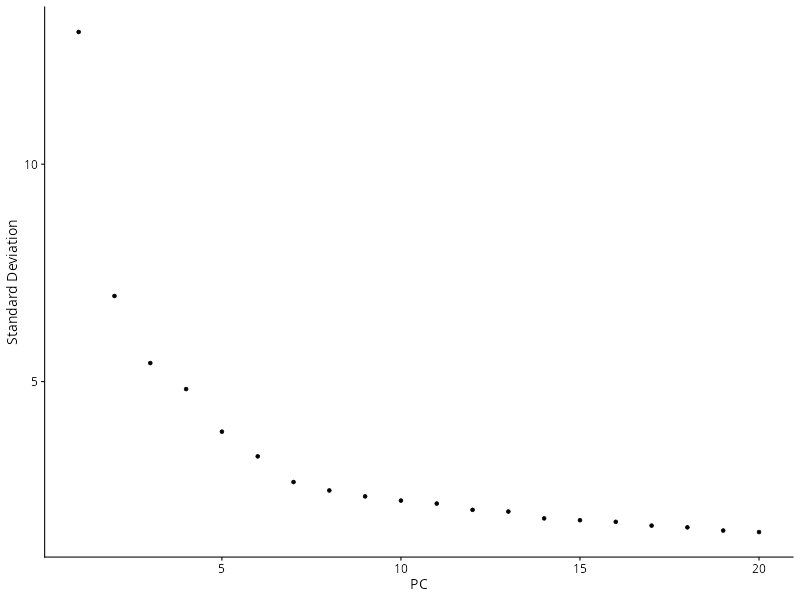

In [13]:
# Scale, PCA
pbmc <- ScaleData(pbmc, features = VariableFeatures(pbmc))
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
ElbowPlot(pbmc)



In [14]:
# Neighborhood graph, clustering and UMAP
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)
pbmc <- RunUMAP(pbmc, dims = 1:10)



Computing nearest neighbor graph
Computing SNN
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10628
Number of edges: 363987

Running Louvain algorithm...


0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


Maximum modularity in 10 random starts: 0.9136
Number of communities: 12
Elapsed time: 1 seconds


To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session


12:01:26 UMAP embedding parameters a = 0.9922 b = 1.112
12:01:27 Read 10628 rows and found 10 numeric columns
12:01:27 Using Annoy for neighbor search, n_neighbors = 30
12:01:27 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
12:01:28 Writing NN index file to temp file /tmp/RtmpsSvpai/file3db72045bcf831
12:01:28 Searching Annoy index using 1 thread, search_k = 3000
12:01:31 Annoy recall = 100%
12:01:31 Commencing smooth kNN distance calibration using 1 thread with target n_neighbors = 30
12:01:32 Initializing from normalized Laplacian + noise (using irlba)
12:01:32 Commencing optimization for 200 epochs, with 431900 positive edges
12:01:32 Using rng type: pcg


Using method 'umap'
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


12:01:38 Optimization finished


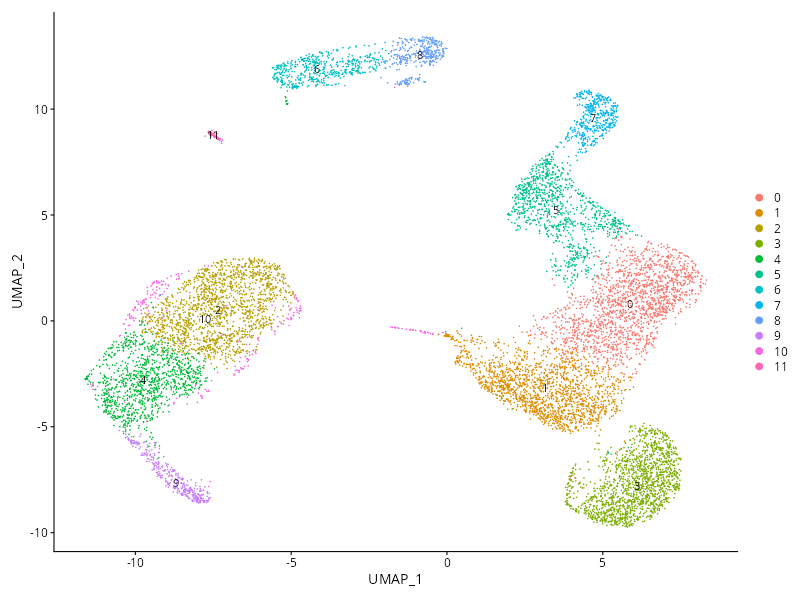

In [15]:
# Plot UMAP
DimPlot(pbmc, reduction = "umap", label = TRUE)

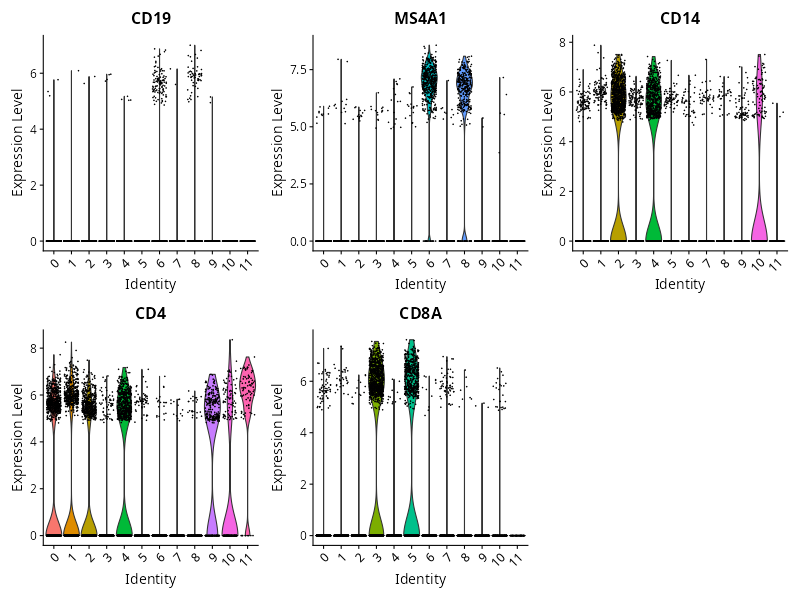

In [16]:
options(repr.plot.width = 15, repr.plot.height = 10) 

VlnPlot(pbmc, features = c("CD19","MS4A1","CD14","CD4","CD8A"))


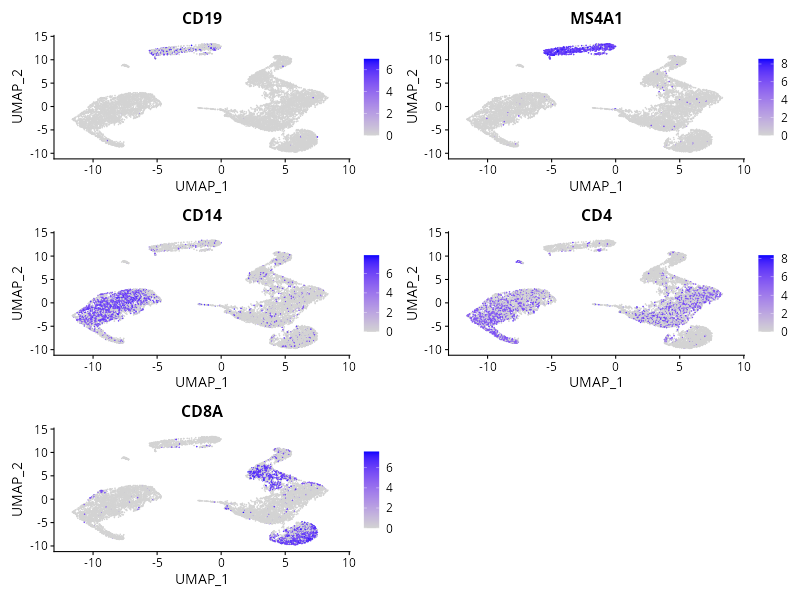

In [17]:
options(repr.plot.width = 12, repr.plot.height = 13) 
FeaturePlot(pbmc, features = c("CD19","MS4A1","CD14","CD4","CD8A"))

In [18]:
pbmc = SetIdent(pbmc,value = "RNA_snn_res.0.5")

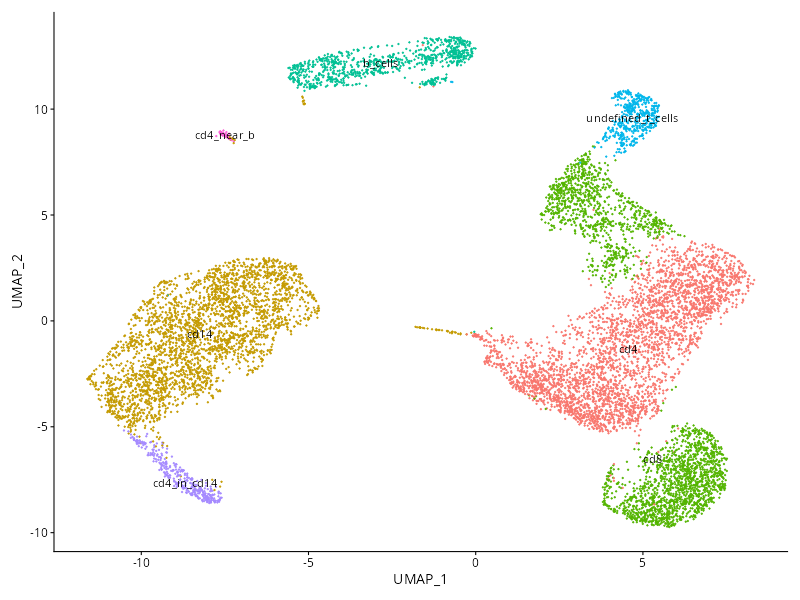

In [19]:
# set clusters based on marker genes
cd4_clusters = c(0,1)
cd4_in_cd14 = c(9)
cd4_near_b = c(11)
cd8_clusters = c(3,5)
cd14_clusters = c(2,10,4)
b_clusters = c(6,8)
undefined_t_cells = c(7) 
all_values <- c(cd4_clusters, cd4_in_cd14, cd4_near_b, cd8_clusters, cd14_clusters, b_clusters, undefined_t_cells)
all_names = c(rep("cd4", length(cd4_clusters)),
                rep("cd4_in_cd14", length(cd4_in_cd14)),
                rep("cd4_near_b", length(cd4_near_b)),
                rep("cd8", length(cd8_clusters)),
                rep("cd14", length(cd14_clusters)),
                rep("b_cells", length(b_clusters)),
                rep("undefined_t_cells", length(undefined_t_cells))
                )

names(all_values) <- all_names
#order all_values by value
all_values = all_values[order(all_values)]
new.cluster.ids = names(all_values) 
names(new.cluster.ids) <- levels(pbmc)

pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()



In [ ]:
if (!interactive()){ 
saveRDS(object = as.data.frame(pbmc@active.ident),file = idents_out_path)
saveRDS(object = lib_size_gex,file = lib_size_out_path)
saveRDS(object = Embeddings(pbmc, reduction = "pca"),file = rna_pca_out_path)
}


In [ ]:
dim(Embeddings(pbmc, reduction = "pca"))

                            PC_1          PC_2          PC_3          PC_4          PC_5          PC_6
AAACAGCCAATCCCTT-1  -9.375915813 -2.7616290265 -2.912445e-01  0.8277979945 -2.530844e-01 -5.000611e+00
AAACAGCCAATGCGCT-1  -8.495196842 -1.1733681883  3.546127e+00  2.2468577633 -4.038549e-02  4.023464e-01
AAACAGCCACACTAAT-1 -10.432592265 -2.4872021074  3.123852e+00 -0.0454653684 -3.735057e-01  3.156265e+00
AAACAGCCACCAACCG-1  -8.466728858 -2.0369530234  2.860766e+00  1.5491056294 -7.590767e-01  1.773311e+00
AAACAGCCAGGATAAC-1  -9.843114334 -1.5968422183  4.409045e+00  0.6998321988 -3.662683e-01  1.623495e+00
AAACAGCCAGTTTACG-1  -8.195469706 -2.4754957221  3.268033e+00  0.9344949695 -4.246416e-01 -5.877526e+00
AAACATGCAAGGTCCT-1 -10.076434805 -2.6955079926  4.339763e+00  1.1996108906 -3.590282e-01  4.565373e+00
AAACATGCACCGGCTA-1  -6.188755030 -4.6186289294 -2.075224e+01 -3.2899410693  2.148816e+00  5.128696e+00
AAACATGCACTTGTTC-1  -9.569428236 -1.6239493975  4.230662e+00  0.637449635